In [1]:
# Library Package
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

# Folder Path
files = './training/training_May-16-2019.csv'

# Regular Expression
regex_wage = r'(\$[0-9,]{2,}[kK]?)'
regex_pday = r'(per day)|(p.d)'
regex_html = r'(<[^>]+>)'

%matplotlib inline

In [2]:
frame = pd.read_csv(files, sep='|')
frame.head()

,content,industries,location,title,type_empl,url,wage
0,Queensland Audit Office Investing in analytics...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/38867796?type=prom...,NaN
1,Our client has a significant track record of d...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Data Scientist - Analytics and AI Job in Brisb...,Full Time,https://www.seek.com.au/job/38999685?type=stan...,NaN
2,Working for this market leader within the Fina...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Head of Data Analytics & Performance Job in Br...,Full Time,https://www.seek.com.au/job/38986499?type=stan...,NaN
3,Full-Time | Permanent | Brisbane CBD About RAC...,Sales,"Brisbane, CBD & Inner Suburbs",Senior Data Analytics Consultant Job in Brisba...,Full Time,https://www.seek.com.au/job/38985472?type=stan...,NaN
4,Queensland Audit Office Investing in analytics...,Science & Technology,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39008519?type=stan...,NaN


In [3]:
frame['wage']

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
5                                                     NaN
6                                                     NaN
7                                                     NaN
8                                                     NaN
9                                                     NaN
10                                                    NaN
11                                                    NaN
12                                                    NaN
13                                                    NaN
14                                     $150-$175k + Super
15                Great salary benefits + Laptop provided
16                            Fantastic New Opportunity!!
17            

In [4]:
# test_string = """
# Sydney, CBD, Inner West & Eastern Suburbs
# Salary
# $700,000 - $1000,000 per day
# Work Type
# Contract/Temp
# Classification
# Information & Communication Technology, Developers/Programmers
# """
# ls = re.findall(regex_wage,test_string)
# print(ls)
# ls = [int(wage.strip("$").replace(",","")) for wage in ls]
# print(ls)
# print(np.mean(ls))

In [5]:
# frame.info()

In [6]:
# frame['wage'].unique()

In [7]:
### Special Cases

# 96,000k
# https://www.seek.com.au/job/39003699?type=standout&searchrequesttoken=1907a61e-aba7-41b1-b94a-37f7f06e0f7c

# 130,000-150,000k
# https://www.seek.com.au/job/38915724?type=standout&searchrequesttoken=d0b07562-538a-480d-ab14-3078fa096fbe

# 90,000k
# https://www.seek.com.au/job/38963567?type=standout&searchrequesttoken=d6ff298d-f248-4cc1-866b-0d7b1c2f1b27

In [8]:
# Split Url out of content
def get_wage(regex, sample):
    result = re.findall(regex, sample)
    per_day = re.search(regex_pday,sample)

    if result:
        # Basic clean.
        result = [value.strip("$").replace(",","").lower() for value in result]
        print("=======================B4: ",result)
        
        # findall might return an duplicate values
        # Reduce the length into 2 first values
        if len(result) >= 2:
            result = result[:2]
            print("I-If: ",result)
            
            # Case-of "k" appears 2times
            if ("k" in result[0]) and ("k" in result[-1]):
                final = int(result[0].strip("k")) + int(result[-1].strip("k"))
                final = final/2
                # Treat special cases
                if final < 1000:
                    final = final*1000
            
            # Case-of "k" appears 1time at last.
            elif ("k" not in result[0]) and ("k" in result[-1]):
                k_value = int(result[-1].strip("k"))
                if k_value < 1000:
                    k_value = k_value*1000
                print(type(k_value))
                print(type(result[0]))
                
                final = (int(result[0]) + k_value)/2
            
            # Case-of "k" appears 1time at first.
            elif ("k" in result[0]) and ("k" not in result[-1]):
                k_value = int(result[0].strip("k"))
                if k_value < 1000:
                    k_value = k_value*1000
                
                final = (k_value + int(result[-1]))/2
                
            elif len(result[0]) < 5 and len(result[-1]) < 5:
                final = np.mean([int(value)*260 for value in result])
                if not per_day:
                    final = final*7.5
            else:
                final = np.mean([int(value) for value in result])
                
            print("O-If: ",final)
            return final
        else:
            result = result[0]
            print("I-Else: ",result)
            
            if "k" in result:
                k_value = int(result.strip("k"))
                # Treat special case
                if k_value < 1000:
                    result = k_value*1000
                else:
                    result = k_value
            elif len(result) < 5:
                result = int(result)*260
                if not per_day:
                    result = int(result)*7.5
            else:
                result = int(result)
            print("O-Else: ", result)
            print("========\n")
            return result
    else:
        return 0

In [9]:
frame['wage'] = frame['wage'].map(lambda row: get_wage(regex_wage,str(row)))

=======================B4:  ['150', '175k']
I-If:  ['150', '175k']
<class 'int'>
<class 'str'>
O-If:  87575.0
=======================B4:  ['111526', '116836']
I-If:  ['111526', '116836']
O-If:  114181.0
=======================B4:  ['82748', '92747']
I-If:  ['82748', '92747']
O-If:  87747.5
=======================B4:  ['111526', '116836']
I-If:  ['111526', '116836']
O-If:  114181.0
=======================B4:  ['82748', '92747']
I-If:  ['82748', '92747']
O-If:  87747.5
=======================B4:  ['130000', '170000']
I-If:  ['130000', '170000']
O-If:  150000.0
=======================B4:  ['180k', '240k']
I-If:  ['180k', '240k']
O-If:  210000.0
=======================B4:  ['98735', '106848']
I-If:  ['98735', '106848']
O-If:  102791.5
=======================B4:  ['84667', '92024', '84667', '92024', '84667', '92024', '84667', '92024']
I-If:  ['84667', '92024']
O-If:  88345.5
=======================B4:  ['130k', '150k']
I-If:  ['130k', '150k']
O-If:  140000.0
=======================B4:  ['82

I-If:  ['600', '700']
O-If:  1267500.0
=======================B4:  ['600']
I-Else:  600
O-Else:  156000

=======================B4:  ['97047', '109194']
I-If:  ['97047', '109194']
O-If:  103120.5
=======================B4:  ['800']
I-Else:  800
O-Else:  208000

=======================B4:  ['120k', '150k']
I-If:  ['120k', '150k']
O-If:  135000.0
=======================B4:  ['100000', '115000']
I-If:  ['100000', '115000']
O-If:  107500.0
=======================B4:  ['70000', '80000']
I-If:  ['70000', '80000']
O-If:  75000.0
=======================B4:  ['50000', '55000']
I-If:  ['50000', '55000']
O-If:  52500.0
=======================B4:  ['90k', '110k']
I-If:  ['90k', '110k']
O-If:  100000.0
=======================B4:  ['75000', '84999']
I-If:  ['75000', '84999']
O-If:  79999.5
=======================B4:  ['140k']
I-Else:  140k
O-Else:  140000

=======================B4:  ['800']
I-Else:  800
O-Else:  1560000.0

=======================B4:  ['160000', '179999']
I-If:  ['160000', '179999']

=======================B4:  ['650', '750']
I-If:  ['650', '750']
O-If:  182000.0
=======================B4:  ['120k']
I-Else:  120k
O-Else:  120000

=======================B4:  ['400', '550']
I-If:  ['400', '550']
O-If:  123500.0
=======================B4:  ['100k', '110k']
I-If:  ['100k', '110k']
O-If:  105000.0
=======================B4:  ['300', '400']
I-If:  ['300', '400']
O-If:  682500.0
=======================B4:  ['80k']
I-Else:  80k
O-Else:  80000

=======================B4:  ['110000', '120000']
I-If:  ['110000', '120000']
O-If:  115000.0
=======================B4:  ['83151', '90006', '83151', '90006']
I-If:  ['83151', '90006']
O-If:  86578.5
=======================B4:  ['85000', '95000']
I-If:  ['85000', '95000']
O-If:  90000.0
=======================B4:  ['87249', '95695']
I-If:  ['87249', '95695']
O-If:  91472.0
=======================B4:  ['87249', '95695']
I-If:  ['87249', '95695']
O-If:  91472.0
=======================B4:  ['400', '600']
I-If:  ['400', '600']
O-If:  1300

O-If:  95000.0
=======================B4:  ['160k', '200k']
I-If:  ['160k', '200k']
O-If:  180000.0
=======================B4:  ['125000']
I-Else:  125000
O-Else:  125000

=======================B4:  ['160k', '180k']
I-If:  ['160k', '180k']
O-If:  170000.0
=======================B4:  ['120k']
I-Else:  120k
O-Else:  120000

=======================B4:  ['200k']
I-Else:  200k
O-Else:  200000

=======================B4:  ['300', '350']
I-If:  ['300', '350']
O-If:  84500.0
=======================B4:  ['150k', '200k']
I-If:  ['150k', '200k']
O-If:  175000.0
=======================B4:  ['80000', '100000']
I-If:  ['80000', '100000']
O-If:  90000.0
=======================B4:  ['1500']
I-Else:  1500
O-Else:  390000

=======================B4:  ['550', '650']
I-If:  ['550', '650']
O-If:  1170000.0
=======================B4:  ['80', '100']
I-If:  ['80', '100']
O-If:  175500.0
=======================B4:  ['450', '500']
I-If:  ['450', '500']
O-If:  123500.0
=======================B4:  ['131k']
I-Els

O-If:  102375.0
=======================B4:  ['130000', '260000']
I-If:  ['130000', '260000']
O-If:  195000.0
=======================B4:  ['55k', '70k']
I-If:  ['55k', '70k']
O-If:  62500.0
=======================B4:  ['150k']
I-Else:  150k
O-Else:  150000

=======================B4:  ['150k', '160k']
I-If:  ['150k', '160k']
O-If:  155000.0
=======================B4:  ['55', '65']
I-If:  ['55', '65']
O-If:  117000.0
=======================B4:  ['27', '35', '27', '35']
I-If:  ['27', '35']
O-If:  8060.0
=======================B4:  ['1450']
I-Else:  1450
O-Else:  2827500.0

=======================B4:  ['600', '800']
I-If:  ['600', '800']
O-If:  1365000.0
=======================B4:  ['65000', '75000']
I-If:  ['65000', '75000']
O-If:  70000.0
=======================B4:  ['950', '1040']
I-If:  ['950', '1040']
O-If:  258700.0
=======================B4:  ['140000', '170000']
I-If:  ['140000', '170000']
O-If:  155000.0
=======================B4:  ['93233', '110172']
I-If:  ['93233', '110172']
O-

=======================B4:  ['120k', '120k']
I-If:  ['120k', '120k']
O-If:  120000.0
=======================B4:  ['250', '300']
I-If:  ['250', '300']
O-If:  71500.0
=======================B4:  ['70k', '100k']
I-If:  ['70k', '100k']
O-If:  85000.0
=======================B4:  ['150000', '180000']
I-If:  ['150000', '180000']
O-If:  165000.0
=======================B4:  ['850']
I-Else:  850
O-Else:  1657500.0

=======================B4:  ['100000', '109999']
I-If:  ['100000', '109999']
O-If:  104999.5
=======================B4:  ['90000', '100000']
I-If:  ['90000', '100000']
O-If:  95000.0
=======================B4:  ['120000', '135000']
I-If:  ['120000', '135000']
O-If:  127500.0
=======================B4:  ['90k', '100k']
I-If:  ['90k', '100k']
O-If:  95000.0
=======================B4:  ['135', '144521']
I-If:  ['135', '144521']
O-If:  72328.0
=======================B4:  ['85000', '95000']
I-If:  ['85000', '95000']
O-If:  90000.0
=======================B4:  ['800']
I-Else:  800
O-Else:  1

O-If:  115000.0
=======================B4:  ['120000', '139999']
I-If:  ['120000', '139999']
O-If:  129999.5
=======================B4:  ['500', '700']
I-If:  ['500', '700']
O-If:  1170000.0
=======================B4:  ['35', '45']
I-If:  ['35', '45']
O-If:  78000.0
=======================B4:  ['80000']
I-Else:  80000
O-Else:  80000

=======================B4:  ['110k', '135600']
I-If:  ['110k', '135600']
O-If:  122800.0
=======================B4:  ['600', '700']
I-If:  ['600', '700']
O-If:  1267500.0
=======================B4:  ['1450']
I-Else:  1450
O-Else:  377000

=======================B4:  ['110k', '120k']
I-If:  ['110k', '120k']
O-If:  115000.0
=======================B4:  ['800', '850']
I-If:  ['800', '850']
O-If:  1608750.0
=======================B4:  ['100k', '110k']
I-If:  ['100k', '110k']
O-If:  105000.0
=======================B4:  ['700']
I-Else:  700
O-Else:  1365000.0

=======================B4:  ['90']
I-Else:  90
O-Else:  175500.0

=======================B4:  ['80000', 


=======================B4:  ['65000', '74999']
I-If:  ['65000', '74999']
O-If:  69999.5
=======================B4:  ['180k', '197100']
I-If:  ['180k', '197100']
O-If:  188550.0
=======================B4:  ['40000']
I-Else:  40000
O-Else:  40000

=======================B4:  ['120k', '130k']
I-If:  ['120k', '130k']
O-If:  125000.0
=======================B4:  ['80000', '119999']
I-If:  ['80000', '119999']
O-If:  99999.5
=======================B4:  ['140k']
I-Else:  140k
O-Else:  140000

=======================B4:  ['90000', '110000']
I-If:  ['90000', '110000']
O-If:  100000.0
=======================B4:  ['90000', '110000']
I-If:  ['90000', '110000']
O-If:  100000.0
=======================B4:  ['650']
I-Else:  650
O-Else:  169000

=======================B4:  ['130', '150']
I-If:  ['130', '150']
O-If:  273000.0
=======================B4:  ['50', '65']
I-If:  ['50', '65']
O-If:  112125.0
=======================B4:  ['700', '750']
I-If:  ['700', '750']
O-If:  188500.0
=======================

=======================B4:  ['89251', '95800', '100849', '119753', '89251', '95800', '100849', '119753']
I-If:  ['89251', '95800']
O-If:  92525.5
=======================B4:  ['89251', '95800', '100849', '119753', '89251', '95800', '100849', '119753']
I-If:  ['89251', '95800']
O-If:  92525.5
=======================B4:  ['85000', '89999']
I-If:  ['85000', '89999']
O-If:  87499.5
=======================B4:  ['60', '60', '60']
I-If:  ['60', '60']
O-If:  117000.0
=======================B4:  ['75000', '90000']
I-If:  ['75000', '90000']
O-If:  82500.0
=======================B4:  ['101282', '109625', '101282', '109625']
I-If:  ['101282', '109625']
O-If:  105453.5
=======================B4:  ['101282', '109625', '101282', '109625']
I-If:  ['101282', '109625']
O-If:  105453.5
=======================B4:  ['900', '1000']
I-If:  ['900', '1000']
O-If:  247000.0
=======================B4:  ['450', '500']
I-If:  ['450', '500']
O-If:  123500.0
=======================B4:  ['113k', '132k']
I-If:  ['113k'

I-If:  ['25', '26']
O-If:  49725.0
=======================B4:  ['400k', '600k']
I-If:  ['400k', '600k']
O-If:  500000.0
=======================B4:  ['110000']
I-Else:  110000
O-Else:  110000

=======================B4:  ['160k']
I-Else:  160k
O-Else:  160000

=======================B4:  ['80k']
I-Else:  80k
O-Else:  80000

=======================B4:  ['90k', '100k']
I-If:  ['90k', '100k']
O-If:  95000.0
=======================B4:  ['15900', '15900', '15900', '15900']
I-If:  ['15900', '15900']
O-If:  15900.0
=======================B4:  ['63594', '80937']
I-If:  ['63594', '80937']
O-If:  72265.5
=======================B4:  ['63594', '80937']
I-If:  ['63594', '80937']
O-If:  72265.5
=======================B4:  ['120000', '135000']
I-If:  ['120000', '135000']
O-If:  127500.0
=======================B4:  ['50k', '60k']
I-If:  ['50k', '60k']
O-If:  55000.0
=======================B4:  ['65000', '79999']
I-If:  ['65000', '79999']
O-If:  72499.5


In [10]:
frame['wage'] = frame['wage'].astype('int64')
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5529 entries, 0 to 5528
Data columns (total 7 columns):
content       5518 non-null object
industries    5518 non-null object
location      5518 non-null object
title         5518 non-null object
type_empl     5518 non-null object
url           5529 non-null object
wage          5529 non-null int64
dtypes: int64(1), object(6)
memory usage: 302.4+ KB


In [11]:
frame['wage'].unique()

array([      0,   87575,  114181,   87747,  150000,  210000,  102791,
         88345,  140000,   85572,  115000,   99961,  174590,  135000,
         79262,  120000,  214500,   67499,   92924,  177450,   95000,
        102831,  102365,  112529,  104124,   78000,  132500,  201500,
        173550,  117537,  100534,   80000,  204750,  136500,   97500,
        189150,  146250,  182000,   75075,  104999,   59999,  202800,
         82875,  100000,  114999,   90000,  185250,   84825,  108225,
         92500,  216320,  182325,   83850,  143000, 1560000,  390000,
       2340000,  125000,  170000,   85000,   82500,  215000,  156000,
        828750,   75135,  200000,   82499,  157500, 1291875,   35532,
        130000,  175500, 1218750,  106316,   86578, 1413750,  116978,
        149500,   87499,  119999,   69580,  108480,   77500,   79999,
        103120,  110000, 1267500,  208000,  107500,   75000,   52500,
        169999,  160000,  234000,  104000,  132360,   81489,    8060,
        142500,  132

In [12]:
frame[frame['wage'] > 1000000]

,content,industries,location,title,type_empl,url,wage
557,Data Scientist required to join the Data & Ana...,Information & Communication Technology,Melbourne,Data Scientist Job in Melbourne - SEEK,Contract/Temp,https://www.seek.com.au/job/38965720?type=stan...,1560000
582,In this exciting contract opportunity we are l...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Senior Data Scientist / Data Products Consult...,Contract/Temp,https://www.seek.com.au/job/39029403?type=stan...,2340000
679,Charterhouse are currently partnering with a w...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Reporting Analyst Job in Melbourne - SEEK,Contract/Temp,https://www.seek.com.au/job/38974588?type=stan...,1291875
729,About the company My client is the world's lar...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Data/Reporting Analyst Job in Melbourne - SEEK,Contract/Temp,https://www.seek.com.au/job/38922640?type=stan...,1218750
747,PM-Partners group is a specialist Project Mana...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Data Analyst - Data Remediation & Reporting Jo...,Contract/Temp,https://www.seek.com.au/job/38830207?type=stan...,1413750
857,We are seeking a Reporting Analyst for our tel...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Reporting Analyst Job in Melbourne - SEEK,Full Time,https://www.seek.com.au/job/38975520?type=stan...,1267500
911,IT Trainer and Data Cleanser for Zycus System ...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Zycus Trainer/ Data Cleanser Job in Melbourne ...,Contract/Temp,https://www.seek.com.au/job/38988279?type=stan...,1560000
1240,SME Business Analyst to work under minimal sup...,Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Business Analyst - Asset Management Project Jo...,Contract/Temp,https://www.seek.com.au/job/38990026?type=stan...,1072500
1292,"An experienced, technical business analyst is ...",Information & Communication Technology,"Melbourne, CBD & Inner Suburbs",Technical Business Analyst Job in Melbourne -...,Contract/Temp,https://www.seek.com.au/job/39001603?type=stan...,1462500
1381,Marketing Cloud Business Analyst - Melbourne -...,Information & Communication Technology,Melbourne,Marketing Cloud Business Analyst Job in Melbou...,Contract/Temp,https://www.seek.com.au/job/38976279?type=stan...,1023750


In [13]:
frame1 = frame[frame['wage'] > 0]
frame1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 14 to 5524
Data columns (total 7 columns):
content       1261 non-null object
industries    1261 non-null object
location      1261 non-null object
title         1261 non-null object
type_empl     1261 non-null object
url           1261 non-null object
wage          1261 non-null int64
dtypes: int64(1), object(6)
memory usage: 78.8+ KB


In [14]:
frame1['location'].value_counts()

Sydney, CBD, Inner West & Eastern Suburbs      511
Melbourne, CBD & Inner Suburbs                 200
Sydney                                          87
Brisbane, CBD & Inner Suburbs                   79
Sydney, North Shore & Northern Beaches          73
Sydney, Parramatta & Western Suburbs            72
Melbourne                                       40
Melbourne, Bayside & South Eastern Suburbs      38
Sydney, Ryde & Macquarie Park                   30
Brisbane                                        26
Melbourne, Western Suburbs                      22
Melbourne, Eastern Suburbs                      19
Sydney, South West & M5 Corridor                14
Melbourne, Northern Suburbs                     10
Sydney, Southern Suburbs & Sutherland Shire     10
Sydney, North West & Hills District              9
Brisbane, Northern Suburbs                       7
Brisbane, Bayside & Eastern Suburbs              5
Brisbane, Southern Suburbs & Logan               5
Brisbane, Western Suburbs & Ips

In [15]:
frame1['industries'].value_counts()

Information & Communication Technology    498
Accounting                                110
Marketing & Communications                103
Education & Training                       79
Government & Defence                       66
Science & Technology                       59
Banking & Financial Services               56
Healthcare & Medical                       52
Sales                                      44
Administration & Office Support            39
Manufacturing, Transport & Logistics       27
Human Resources & Recruitment              24
Consulting & Strategy                      23
Engineering                                21
Insurance & Superannuation                 13
Advertising, Arts & Media                  10
Community Services & Development            8
Retail & Consumer Products                  5
Call Centre & Customer Service              5
Legal                                       4
Design & Architecture                       4
Mining, Resources & Energy        

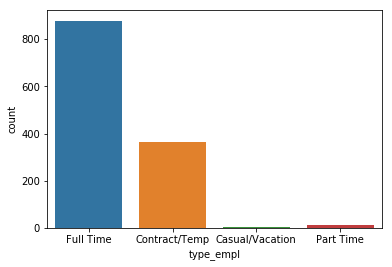

In [16]:
frame1['type_empl'].value_counts()
sns.countplot(x='type_empl',data=frame1)

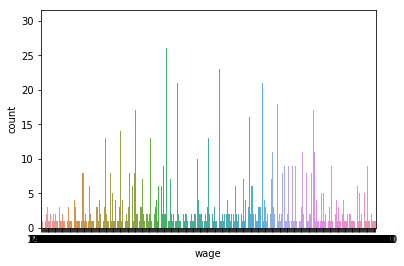

In [24]:
sns.countplot(x='wage',data=frame1, orient='v')

In [18]:
frame1['wage'].value_counts()

120000     30
100000     29
140000     28
130000     28
90000      26
115000     24
110000     23
95000      21
208000     21
135000     21
150000     18
195000     17
80000      17
125000     16
75000      14
70000      13
105000     13
85000      13
145000     11
200000     11
175500     11
102500     10
89251       9
156000      9
160000      9
234000      9
1560000     9
169000      9
170000      9
182000      8
           ..
1608750     1
85070       1
73125       1
1852500     1
26000       1
1072500     1
71000       1
828750      1
204100      1
75065       1
177450      1
218400      1
50450       1
208130      1
216320      1
64750       1
93421       1
2827500     1
74981       1
113880      1
546000      1
101000      1
2340000     1
58500       1
58499       1
99450       1
140400      1
109200      1
40030       1
169999      1
Name: wage, Length: 381, dtype: int64

In [19]:
frame1['content'] = frame1['content'].map(lambda row: re.sub(regex_html,'',row))

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
no = 0
print(frame1['url'].iloc[no])
print("======================")
print(frame1['wage'].iloc[no])
print("======================")
frame1['content'].iloc[no]

https://www.seek.com.au/job/38892320?type=standard&searchrequesttoken=923213a8-5d05-4bba-ac2c-0e93b7641580
87575


"Over the last 2 years this business has been steadily investing in it's Data Analytics & Science capability, adding to their existing BI and Engineering teams. With a current team size of 3, this role will be a senior appointment and requires someone with senior experience. Company This business is a leader in their field & has been for circa 50 years as a specialist financial product supplier. Based in Brisbane's CBD with spectacular offices near the station; they are renown for their employee's fulfilment, happiness and retention; people love working here. Saying that, they're quite niche so being renown would definitely be an inter-industry statement! With strong industry partner's, they're embarking on a journey to scale up their Customer Experience and Data Analytics teams, continuing to develop as a performing business & further improve it's customer retention. Role This position was created to challenge the status-quo and teams to re-evaluate current and future solutions for th